### Initialize the model

In [ ]:
from keras_segmentation.models.fcn import fcn_8_vgg

model = fcn_8_vgg(n_classes=3 ,  input_height=256, input_width=256  )


2025-07-07 03:29:45.490451: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-07 03:29:45.493235: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-07 03:29:45.501142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751851785.514560  301841 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751851785.518376  301841 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751851785.529069  301841 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Use three variables to create RGB images

In [1]:
input_variables = ['thetao', 'so', 'o2']
predict = 'catch'


In [10]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm

def normalize_array(arr):
    """Normalize array to 0-255 range for image creation"""
    arr_min = np.nanmin(arr)
    arr_max = np.nanmax(arr)
    if arr_max == arr_min:
        return np.zeros_like(arr, dtype=np.uint8)
    normalized = (arr - arr_min) / (arr_max - arr_min) * 255
    return normalized.astype(np.uint8)

def load_and_process_variable(file_path):
    """Load a PNG file and convert to normalized array"""
    try:
        img = Image.open(file_path)
        arr = np.array(img)
        
        # Handle different image modes
        if img.mode == 'RGBA':
            # Use the first channel (RGB) and ignore alpha
            arr = arr[:, :, 0]
        elif img.mode == 'RGB':
            # Convert to grayscale
            arr = np.mean(arr, axis=2)
        elif len(arr.shape) == 3 and arr.shape[2] == 1:
            # Single channel
            arr = arr[:, :, 0]
        
        # Ensure we have a 2D array
        if len(arr.shape) > 2:
            arr = arr[:, :, 0]
            
        return normalize_array(arr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def create_rgb_image(date, base_path, variables):
    """Create RGB image from three variables for a specific date"""
    channels = []
    
    for var in variables:
        var_path = os.path.join(base_path, var, f"{date}.png")
        if os.path.exists(var_path):
            channel = load_and_process_variable(var_path)
            if channel is not None:
                channels.append(channel)
            else:
                print(f"Failed to load {var_path}")
                return None
        else:
            print(f"File not found: {var_path}")
            return None
    
    if len(channels) == 3:
        # Ensure all channels have the same shape
        min_height = min(ch.shape[0] for ch in channels)
        min_width = min(ch.shape[1] for ch in channels)
        
        # Crop all channels to the same size
        cropped_channels = []
        for ch in channels:
            cropped = ch[:min_height, :min_width]
            cropped_channels.append(cropped)
        
        # Stack channels to create RGB image
        rgb_image = np.stack(cropped_channels, axis=-1)
        return rgb_image
    else:
        return None

def create_skagerakk_dataset(source_path, output_path, input_vars, target_var):
    """Create the skagerakk_dataset with RGB images and target annotations"""
    
    # Create output directory structure
    train_images_dir = os.path.join(output_path, "images_prepped_train")
    train_annotations_dir = os.path.join(output_path, "annotations_prepped_train")
    test_images_dir = os.path.join(output_path, "images_prepped_test")
    test_annotations_dir = os.path.join(output_path, "annotations_prepped_test")
    
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_annotations_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_annotations_dir, exist_ok=True)
    
    # Process train set
    train_path = os.path.join(source_path, "train")
    train_success = 0
    
    if os.path.exists(train_path):
        # Get all dates from the first variable in train
        first_var_train = os.path.join(train_path, input_vars[0])
        if os.path.exists(first_var_train):
            train_dates = [f.replace('.png', '') for f in os.listdir(first_var_train) if f.endswith('.png')]
            train_dates.sort()
            
            print(f"Processing {len(train_dates)} training images...")
            
            for date in tqdm(train_dates, desc="Creating train RGB images"):
                # Create RGB input image
                rgb_image = create_rgb_image(date, train_path, input_vars)
                
                # Copy target annotation
                target_path = os.path.join(train_path, target_var, f"{date}.png")
                
                if rgb_image is not None and os.path.exists(target_path):
                    # Save RGB input image
                    input_file = os.path.join(train_images_dir, f"{date}.png")
                    pil_image = Image.fromarray(rgb_image, mode='RGB')
                    pil_image.save(input_file)
                    
                    # Copy target annotation
                    annotation_file = os.path.join(train_annotations_dir, f"{date}.png")
                    target_img = Image.open(target_path)
                    target_img.save(annotation_file)
                    
                    train_success += 1
            
            print(f"Successfully created {train_success} training pairs")
    
    # Process test set
    test_path = os.path.join(source_path, "test")
    test_success = 0
    
    if os.path.exists(test_path):
        # Get all dates from the first variable in test
        first_var_test = os.path.join(test_path, input_vars[0])
        if os.path.exists(first_var_test):
            test_dates = [f.replace('.png', '') for f in os.listdir(first_var_test) if f.endswith('.png')]
            test_dates.sort()
            
            print(f"Processing {len(test_dates)} test images...")
            
            for date in tqdm(test_dates, desc="Creating test RGB images"):
                # Create RGB input image
                rgb_image = create_rgb_image(date, test_path, input_vars)
                
                # Copy target annotation
                target_path = os.path.join(test_path, target_var, f"{date}.png")
                
                if rgb_image is not None and os.path.exists(target_path):
                    # Save RGB input image
                    input_file = os.path.join(test_images_dir, f"{date}.png")
                    pil_image = Image.fromarray(rgb_image, mode='RGB')
                    pil_image.save(input_file)
                    
                    # Copy target annotation
                    annotation_file = os.path.join(test_annotations_dir, f"{date}.png")
                    target_img = Image.open(target_path)
                    target_img.save(annotation_file)
                    
                    test_success += 1
            
            print(f"Successfully created {test_success} test pairs")
    
    return train_success, test_success

# Create the skagerakk_dataset using the defined variables
source_dataset = "/home/anna/msc_oppgave/image-segmentation/test128x128GAT_19to24_100p"
output_dataset = "/home/anna/msc_oppgave/image-segmentation/skagerakk_dataset"

print("Creating skagerakk_dataset...")
print(f"Input variables (RGB channels): {input_variables}")
print(f"Target variable: {predict}")
print(f"Source: {source_dataset}")
print(f"Output: {output_dataset}")

train_count, test_count = create_skagerakk_dataset(source_dataset, output_dataset, input_variables, predict)

print(f"\nDataset creation complete!")
print(f"Train pairs: {train_count}")
print(f"Test pairs: {test_count}")
print(f"Total pairs: {train_count + test_count}")

# Show sample image info
if train_count > 0:
    sample_train_path = os.path.join(output_dataset, "images_prepped_train")
    sample_files = [f for f in os.listdir(sample_train_path) if f.endswith('.png')]
    if sample_files:
        sample_file = sample_files[0]
        sample_image = Image.open(os.path.join(sample_train_path, sample_file))
        
        print(f"\nSample image info:")
        print(f"Input image: {sample_file}")
        print(f"Shape: {np.array(sample_image).shape}")
        print(f"Mode: {sample_image.mode}")
        print(f"RGB channels: Red={input_variables[0]}, Green={input_variables[1]}, Blue={input_variables[2]}")
        print(f"Target: {predict}")
        
        # Save a sample to visualize later
        sample_image.save("/home/anna/msc_oppgave/image-segmentation/sample_combined_image.png")
        print(f"Sample saved as: sample_combined_image.png")

print(f"\nDataset structure:")
print(f"- {output_dataset}/images_prepped_train/ (RGB input images)")
print(f"- {output_dataset}/annotations_prepped_train/ ({predict} target images)")
print(f"- {output_dataset}/images_prepped_test/ (RGB input images)")
print(f"- {output_dataset}/annotations_prepped_test/ ({predict} target images)")

Creating skagerakk_dataset...
Input variables (RGB channels): ['thetao', 'so', 'o2']
Target variable: catch
Source: /home/anna/msc_oppgave/image-segmentation/test128x128GAT_19to24_100p
Output: /home/anna/msc_oppgave/image-segmentation/skagerakk_dataset
Processing 439 training images...


Creating train RGB images:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_535604/3263603089.py:112: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(rgb_image, mode='RGB')
Creating train RGB images: 100%|██████████| 439/439 [00:05<00:00, 80.65it/s]


Successfully created 439 training pairs
Processing 110 test images...


Creating test RGB images:   0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipykernel_535604/3263603089.py:147: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(rgb_image, mode='RGB')
Creating test RGB images: 100%|██████████| 110/110 [00:01<00:00, 81.25it/s]

Successfully created 110 test pairs

Dataset creation complete!
Train pairs: 439
Test pairs: 110
Total pairs: 549

Sample image info:
Input image: 2022-08-22.png
Shape: (128, 129, 3)
Mode: RGB
RGB channels: Red=thetao, Green=so, Blue=o2
Target: catch
Sample saved as: sample_combined_image.png

Dataset structure:
- /home/anna/msc_oppgave/image-segmentation/skagerakk_dataset/images_prepped_train/ (RGB input images)
- /home/anna/msc_oppgave/image-segmentation/skagerakk_dataset/annotations_prepped_train/ (catch target images)
- /home/anna/msc_oppgave/image-segmentation/skagerakk_dataset/images_prepped_test/ (RGB input images)
- /home/anna/msc_oppgave/image-segmentation/skagerakk_dataset/annotations_prepped_test/ (catch target images)


Dataset structure:
  train images: 439
  train annotations: 439
  test images: 110
  test annotations: 110


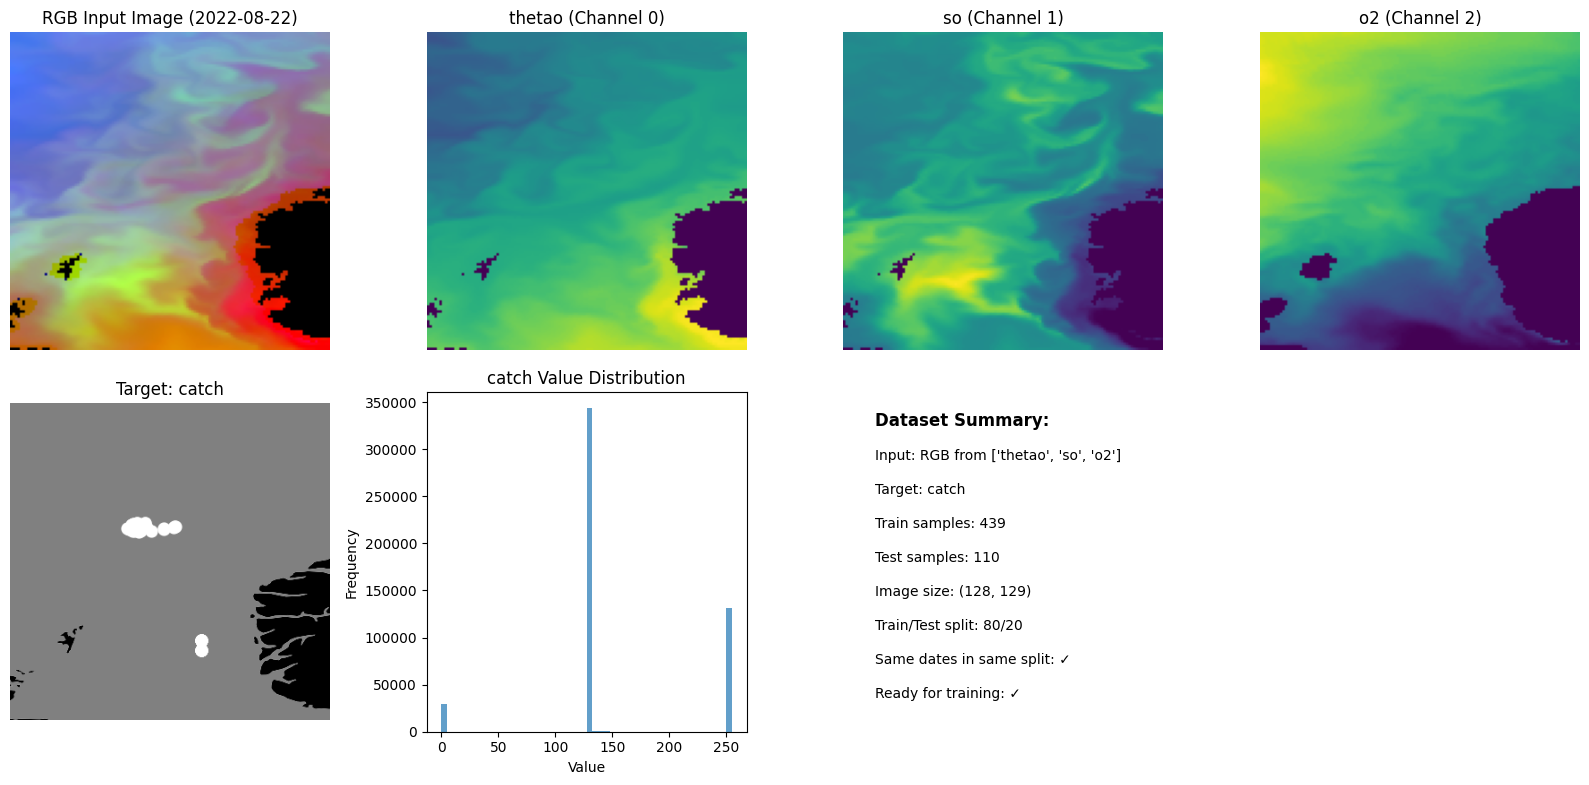


Sample image details:
Input image shape: (128, 129, 3)
Target image shape: (355, 358, 4)
Input value range: 0.00 - 255.00
Target value range: 0.00 - 255.00

Dataset is ready for training!
You can now train the model using the skagerakk_dataset with RGB inputs predicting catch


In [3]:
# Verify the dataset structure and show samples
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

dataset_path = "/home/anna/msc_oppgave/image-segmentation/skagerakk_dataset"

# Check dataset structure
print("Dataset structure:")
for split in ['train', 'test']:
    images_dir = os.path.join(dataset_path, f"images_prepped_{split}")
    annotations_dir = os.path.join(dataset_path, f"annotations_prepped_{split}")
    
    if os.path.exists(images_dir):
        image_count = len([f for f in os.listdir(images_dir) if f.endswith('.png')])
        print(f"  {split} images: {image_count}")
    
    if os.path.exists(annotations_dir):
        annotation_count = len([f for f in os.listdir(annotations_dir) if f.endswith('.png')])
        print(f"  {split} annotations: {annotation_count}")

# Show sample images
sample_date = "2022-08-22"
train_image_path = os.path.join(dataset_path, "images_prepped_train", f"{sample_date}.png")
train_annotation_path = os.path.join(dataset_path, "annotations_prepped_train", f"{sample_date}.png")

if os.path.exists(train_image_path) and os.path.exists(train_annotation_path):
    # Load sample images
    input_img = Image.open(train_image_path)
    target_img = Image.open(train_annotation_path)
    
    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Show RGB input image
    axes[0, 0].imshow(input_img)
    axes[0, 0].set_title(f'RGB Input Image ({sample_date})')
    axes[0, 0].axis('off')
    
    # Show individual channels
    input_array = np.array(input_img)
    for i, var in enumerate(input_variables):
        axes[0, i+1].imshow(input_array[:, :, i], cmap='viridis')
        axes[0, i+1].set_title(f'{var} (Channel {i})')
        axes[0, i+1].axis('off')
    
    # Show target annotation
    axes[1, 0].imshow(target_img, cmap='viridis')
    axes[1, 0].set_title(f'Target: {predict}')
    axes[1, 0].axis('off')
    
    # Show target statistics
    target_array = np.array(target_img)
    axes[1, 1].hist(target_array.flatten(), bins=50, alpha=0.7)
    axes[1, 1].set_title(f'{predict} Value Distribution')
    axes[1, 1].set_xlabel('Value')
    axes[1, 1].set_ylabel('Frequency')
    
    # Summary statistics
    axes[1, 2].text(0.1, 0.9, f'Dataset Summary:', fontsize=12, fontweight='bold')
    axes[1, 2].text(0.1, 0.8, f'Input: RGB from {input_variables}', fontsize=10)
    axes[1, 2].text(0.1, 0.7, f'Target: {predict}', fontsize=10)
    axes[1, 2].text(0.1, 0.6, f'Train samples: 439', fontsize=10)
    axes[1, 2].text(0.1, 0.5, f'Test samples: 110', fontsize=10)
    axes[1, 2].text(0.1, 0.4, f'Image size: {input_array.shape[:2]}', fontsize=10)
    axes[1, 2].text(0.1, 0.3, f'Train/Test split: 80/20', fontsize=10)
    axes[1, 2].text(0.1, 0.2, f'Same dates in same split: ✓', fontsize=10)
    axes[1, 2].text(0.1, 0.1, f'Ready for training: ✓', fontsize=10)
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].axis('off')
    
    # Hide empty subplot
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSample image details:")
    print(f"Input image shape: {input_array.shape}")
    print(f"Target image shape: {target_array.shape}")
    print(f"Input value range: {input_array.min():.2f} - {input_array.max():.2f}")
    print(f"Target value range: {target_array.min():.2f} - {target_array.max():.2f}")
    
else:
    print(f"Sample files not found: {train_image_path} or {train_annotation_path}")

print(f"\nDataset is ready for training!")
print(f"You can now train the model using the skagerakk_dataset with RGB inputs predicting {predict}")

In [ ]:
import os
import numpy as np
from PIL import Image

# Set variables correctly
variables = ['thetao', 'so', 'o2']
print("Variables set to:", variables)

# Test with a single image first
source_dataset = "/home/anna/msc_oppgave/image-segmentation/test128x128GAT_19to24_100p"
sample_date = "2019-08-22"
train_path = os.path.join(source_dataset, "train")

# Test creating RGB for one image
print("Testing RGB creation for sample date:", sample_date)
channels = []

for var in variables:
    var_path = os.path.join(train_path, var, f"{sample_date}.png")
    print(f"Checking {var_path}...")
    if os.path.exists(var_path):
        img = Image.open(var_path)
        arr = np.array(img)
        # Use first channel from RGBA
        channel = arr[:, :, 0]
        channels.append(channel)
        print(f"  {var}: Shape {channel.shape}, min/max: {channel.min()}/{channel.max()}")
    else:
        print(f"  {var}: FILE NOT FOUND")

if len(channels) == 3:
    # Find common dimensions
    min_height = min(ch.shape[0] for ch in channels)
    min_width = min(ch.shape[1] for ch in channels)
    print(f"Common dimensions: {min_height}x{min_width}")
    
    # Crop and normalize
    normalized_channels = []
    for i, ch in enumerate(channels):
        cropped = ch[:min_height, :min_width]
        # Normalize to 0-255
        normalized = ((cropped - cropped.min()) / (cropped.max() - cropped.min()) * 255).astype(np.uint8)
        normalized_channels.append(normalized)
        print(f"  Channel {i} ({variables[i]}): normalized min/max: {normalized.min()}/{normalized.max()}")
    
    # Create RGB image
    rgb_image = np.stack(normalized_channels, axis=-1)
    print(f"RGB image shape: {rgb_image.shape}")
    
    # Save test image
    test_rgb = Image.fromarray(rgb_image, mode='RGB')
    test_rgb.save("/home/anna/msc_oppgave/image-segmentation/test_rgb.png")
    print("Test RGB image saved as test_rgb.png")
else:
    print(f"Error: Only found {len(channels)} channels out of 3")

Debug: Variables = ['var1', 'var2', 'var3']
Debug: Type of variables = <class 'list'>


In [3]:
# Debug: Check the format of the source images
import numpy as np
from PIL import Image

# Check a sample image from each variable
sample_date = "2019-08-22"
base_path = "/home/anna/msc_oppgave/image-segmentation/test128x128GAT_19to24_100p/train"

for var in variables:
    var_path = f"{base_path}/{var}/{sample_date}.png"
    if os.path.exists(var_path):
        img = Image.open(var_path)
        arr = np.array(img)
        print(f"{var}:")
        print(f"  PIL mode: {img.mode}")
        print(f"  Array shape: {arr.shape}")
        print(f"  Array dtype: {arr.dtype}")
        print(f"  Min/Max values: {arr.min()}/{arr.max()}")
        print()

thetao:
  PIL mode: RGBA
  Array shape: (128, 129, 4)
  Array dtype: uint8
  Min/Max values: 0/255

so:
  PIL mode: RGBA
  Array shape: (128, 129, 4)
  Array dtype: uint8
  Min/Max values: 0/255

o2:
  PIL mode: RGBA
  Array shape: (128, 129, 4)
  Array dtype: uint8
  Min/Max values: 0/255



### Train the model

In [ ]:
model.train(
    train_images = "skagerakk_dataset/images_prepped_train/",
    train_annotations = "skagerakk_dataset/annotations_prepped_train/",
    checkpoints_path = "/tmp/skagerakk_fcn8" , epochs=5
)

Verifying training dataset


  0%|          | 0/367 [00:00<?, ?it/s]

100%|██████████| 367/367 [00:01<00:00, 214.57it/s]


Dataset verified! 
Epoch 1/5


2025-07-07 03:29:51.620116: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-07-07 03:29:53.650216: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5340 - loss: 5.7497
Epoch 1: saving model to /tmp/vgg_unet_1.00001.weights.h5
512/512 ━━━━━━━━━━━━━━━━━━━━ 1027s 2s/step - accuracy: 0.5342 - loss: 5.7420
Epoch 2/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6957 - loss: 0.9045
Epoch 2: saving model to /tmp/vgg_unet_1.00002.weights.h5
512/512 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.6958 - loss: 0.9045
Epoch 3/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7245 - loss: 0.8461
Epoch 3: saving model to /tmp/vgg_unet_1.00003.weights.h5
512/512 ━━━━━━━━━━━━━━━━━━━━ 1008s 2s/step - accuracy: 0.7245 - loss: 0.8460
Epoch 4/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7876 - loss: 0.6827
Epoch 4: saving model to /tmp/vgg_unet_1.00004.weights.h5
512/512 ━━━━━━━━━━━━━━━━━━━━ 1014s 2s/step - accuracy: 0.7876 - loss: 0.6827
Epoch 5/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8217 - loss: 0.5786
Epoch 5: saving model to /tmp/vgg_unet_1.00005.weig

### Save Model Weights

You can save the model weights manually after training is complete.

In [11]:
# Method 1: Save only the weights
model.save_weights("my_model_weights.weights.h5")

# Method 2: Save the entire model
model.save("my_complete_model.keras")

# Method 3: Save to a custom path
import os
weights_dir = "saved_models"
os.makedirs(weights_dir, exist_ok=True)
model.save_weights(f"{weights_dir}/fcn8_final_weights.weights.h5")

### Load Saved Weights

To load the weights back into a model later:

In [4]:
from keras_segmentation.models.fcn import fcn_8_vgg
# First create the same model architecture
model = fcn_8_vgg(n_classes=53, input_height=256, input_width=256)

# Then load the weights
model.load_weights("my_model_weights.weights.h5")

# Or load from checkpoint (replace 00005 with the epoch you want)
# new_model.load_weights("/tmp/vgg_unet_1.00005.weights.h5")

2025-07-07 12:58:01.178131: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


### Model Performance Evaluation

Let's evaluate the trained model and get comprehensive performance metrics including:
- Pixel Accuracy
- Mean Accuracy  
- Mean IoU
- Frequency Weighted IoU

In [6]:
# Comprehensive evaluation of the trained model
from keras_segmentation.predict import evaluate
import numpy as np
from tqdm import tqdm

print("Evaluating model performance on test dataset...")
print("This may take a few minutes...")

# Get the built-in evaluation metrics
evaluation_results = evaluate(
    model=model,
    inp_images_dir="dataset1/images_prepped_test/",
    annotations_dir="dataset1/annotations_prepped_test/"
)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Mean IoU: {evaluation_results['mean_IU']:.4f}")
print(f"Frequency Weighted IoU: {evaluation_results['frequency_weighted_IU']:.4f}")
print(f"\nClass-wise IoU scores:")
for i, iou in enumerate(evaluation_results['class_wise_IU']):
    if iou > 0.001:  # Only show classes with meaningful IoU
        print(f"  Class {i:2d}: {iou:.4f}")

Evaluating model performance on test dataset...
This may take a few minutes...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


1it [00:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


2it [00:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


3it [00:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


4it [00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


5it [00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


6it [00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


7it [00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


8it [00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


9it [00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


10it [00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


11it [00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


12it [00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


13it [00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


14it [00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


15it [00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


16it [00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


17it [00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


18it [00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


19it [00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


20it [00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


21it [00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


22it [00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


23it [00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


24it [00:06,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


25it [00:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


26it [00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


27it [00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


28it [00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


29it [00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


30it [00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


31it [00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


32it [00:08,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


33it [00:08,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


34it [00:08,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


35it [00:08,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


36it [00:09,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


37it [00:09,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


38it [00:09,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


39it [00:09,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


40it [00:10,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


41it [00:10,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


42it [00:10,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


43it [00:10,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


44it [00:11,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


45it [00:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


46it [00:11,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


47it [00:11,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


48it [00:12,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


49it [00:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


50it [00:12,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


51it [00:13,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


52it [00:13,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


53it [00:13,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


54it [00:13,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


55it [00:14,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


56it [00:14,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


57it [00:14,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


58it [00:14,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


59it [00:15,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


60it [00:15,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


61it [00:15,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


62it [00:15,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


63it [00:16,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


64it [00:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


65it [00:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


66it [00:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


67it [00:17,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


68it [00:17,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


69it [00:17,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


70it [00:18,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


71it [00:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


72it [00:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


73it [00:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


74it [00:19,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


75it [00:19,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


76it [00:19,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


77it [00:19,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


78it [00:20,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


79it [00:20,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


80it [00:20,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


81it [00:20,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


82it [00:21,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


83it [00:21,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


84it [00:21,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


85it [00:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


86it [00:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


87it [00:22,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


88it [00:22,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


89it [00:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


90it [00:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


91it [00:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


92it [00:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


93it [00:24,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


94it [00:24,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


95it [00:24,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


96it [00:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


97it [00:25,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


98it [00:25,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


99it [00:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


100it [00:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


101it [00:26,  3.84it/s]


MODEL PERFORMANCE METRICS
Mean IoU: 0.0652
Frequency Weighted IoU: 0.5478

Class-wise IoU scores:
  Class  0: 0.8544
  Class  1: 0.5177
  Class  3: 0.9054
  Class  4: 0.6833
  Class  5: 0.0230
  Class  7: 0.1308
  Class  8: 0.2707
  Class 11: 0.0681


In [7]:
# Option 2: Evaluate an already trained model
from keras_segmentation.predict import evaluate
from keras_segmentation.data_utils.data_loader import get_pairs_from_paths, get_segmentation_array
import os
import numpy as np
from tqdm import tqdm

# Evaluate the model on test data
evaluation_results = evaluate(
    model=model,  # or use checkpoints_path="/tmp/vgg_unet_1.00005.weights.h5"
    inp_images_dir="dataset1/images_prepped_test/",
    annotations_dir="dataset1/annotations_prepped_test/"
)

print("Evaluation Results:")
print(f"Mean IoU: {evaluation_results['mean_IU']:.4f}")
print(f"Frequency Weighted IoU: {evaluation_results['frequency_weighted_IU']:.4f}")
print(f"Class-wise IoU: {evaluation_results['class_wise_IU']}")

# Calculate additional metrics: Pixel Accuracy and Mean Accuracy

# Get all test image pairs
test_images_dir = "dataset1/images_prepped_test/"
test_annotations_dir = "dataset1/annotations_prepped_test/"

paths = get_pairs_from_paths(test_images_dir, test_annotations_dir)
test_images = [p[0] for p in paths]
test_annotations = [p[1] for p in paths]

# Initialize counters for pixel accuracy and mean accuracy
total_pixels = 0
correct_pixels = 0
class_correct = np.zeros(model.n_classes)
class_total = np.zeros(model.n_classes)

print("Calculating Pixel Accuracy and Mean Accuracy...")
print(f"Processing {len(test_images)} test images...")

for img_path, ann_path in tqdm(zip(test_images, test_annotations), total=len(test_images)):
    # Make prediction
    pred = model.predict_segmentation(inp=img_path)
    
    # Load ground truth
    gt = get_segmentation_array(ann_path, model.n_classes, 
                               model.output_width, model.output_height, 
                               no_reshape=True)
    gt = gt.argmax(-1)
    
    # Flatten arrays for easier calculation
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()
    
    # Pixel accuracy calculation
    correct_pixels += np.sum(pred_flat == gt_flat)
    total_pixels += len(pred_flat)
    
    # Mean accuracy calculation (per-class accuracy)
    for class_id in range(model.n_classes):
        class_mask = (gt_flat == class_id)
        if np.sum(class_mask) > 0:  # If class is present in ground truth
            class_correct[class_id] += np.sum((pred_flat == class_id) & class_mask)
            class_total[class_id] += np.sum(class_mask)

# Calculate final metrics
pixel_accuracy = correct_pixels / total_pixels
class_accuracies = np.divide(class_correct, class_total, 
                           out=np.zeros_like(class_correct), 
                           where=class_total!=0)
mean_accuracy = np.mean(class_accuracies[class_total > 0])

print("\n" + "="*50)
print("ADDITIONAL PERFORMANCE METRICS")
print("="*50)
print(f"Pixel Accuracy: {pixel_accuracy:.4f} ({pixel_accuracy*100:.2f}%)")
print(f"Mean Accuracy: {mean_accuracy:.4f} ({mean_accuracy*100:.2f}%)")
print(f"\nPer-class Accuracy:")
for i, acc in enumerate(class_accuracies):
    if class_total[i] > 0:
        print(f"  Class {i:2d}: {acc:.4f} ({acc*100:.2f}%) - {int(class_total[i])} pixels")

0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


1it [00:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2it [00:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


3it [00:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


4it [00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


5it [00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


6it [00:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


7it [00:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


8it [00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


9it [00:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


10it [00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


11it [00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


12it [00:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


13it [00:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


14it [00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


15it [00:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


16it [00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


17it [00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


18it [00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


19it [00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


20it [00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


21it [00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


22it [00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


23it [00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


24it [00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


25it [00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


26it [00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


27it [00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


28it [00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


29it [00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


30it [00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


31it [00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


32it [00:08,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


33it [00:08,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


34it [00:08,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


35it [00:08,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


36it [00:09,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


37it [00:09,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


38it [00:09,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


39it [00:09,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


40it [00:10,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


41it [00:10,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


42it [00:10,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


43it [00:10,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


44it [00:11,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


45it [00:11,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


46it [00:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


47it [00:12,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


48it [00:12,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


49it [00:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


50it [00:12,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


51it [00:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


52it [00:13,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


53it [00:13,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


54it [00:13,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


55it [00:14,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


56it [00:14,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


57it [00:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


58it [00:14,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


59it [00:15,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


60it [00:15,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


61it [00:15,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


62it [00:15,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


63it [00:16,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


64it [00:16,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


65it [00:16,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


66it [00:16,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


67it [00:17,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


68it [00:17,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


69it [00:17,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


70it [00:17,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


71it [00:18,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


72it [00:18,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


73it [00:18,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


74it [00:18,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


75it [00:19,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


76it [00:19,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


77it [00:19,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


78it [00:19,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


79it [00:20,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


80it [00:20,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


81it [00:20,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


82it [00:20,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


83it [00:21,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


84it [00:21,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


85it [00:21,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


86it [00:21,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


87it [00:22,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


88it [00:22,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


89it [00:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


90it [00:23,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


91it [00:23,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


92it [00:23,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


93it [00:23,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


94it [00:24,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


95it [00:24,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


96it [00:24,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


97it [00:24,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


98it [00:25,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


99it [00:25,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


100it [00:25,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


101it [00:25,  3.91it/s]


Evaluation Results:
Mean IoU: 0.0652
Frequency Weighted IoU: 0.5478
Class-wise IoU: [8.54437653e-01 5.17729677e-01 0.00000000e+00 9.05398324e-01
 6.83278965e-01 2.30109991e-02 0.00000000e+00 1.30804977e-01
 2.70737210e-01 2.18035932e-05 0.00000000e+00 6.80879501e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Calculating Pixel Accuracy and Mean Accuracy...
Processing 101 test images...


  0%|          | 0/101 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  1%|          | 1/101 [00:00<00:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  2%|▏         | 2/101 [00:00<00:24,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  3%|▎         | 3/101 [00:00<00:24,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  4%|▍         | 4/101 [00:00<00:23,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  5%|▍         | 5/101 [00:01<00:23,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|▌         | 6/101 [00:01<00:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  7%|▋         | 7/101 [00:01<00:22,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  8%|▊         | 8/101 [00:01<00:22,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  9%|▉         | 9/101 [00:02<00:22,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 10%|▉         | 10/101 [00:02<00:22,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 11%|█         | 11/101 [00:02<00:22,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 12%|█▏        | 12/101 [00:02<00:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█▎        | 13/101 [00:03<00:21,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 14%|█▍        | 14/101 [00:03<00:21,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 15%|█▍        | 15/101 [00:03<00:20,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 16%|█▌        | 16/101 [00:03<00:21,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 17%|█▋        | 17/101 [00:04<00:20,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 18%|█▊        | 18/101 [00:04<00:20,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|█▉        | 19/101 [00:04<00:20,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 20%|█▉        | 20/101 [00:04<00:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 21%|██        | 21/101 [00:05<00:19,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 22%|██▏       | 22/101 [00:05<00:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 23%|██▎       | 23/101 [00:05<00:19,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 24%|██▍       | 24/101 [00:05<00:19,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 25%|██▍       | 25/101 [00:06<00:19,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 26%|██▌       | 26/101 [00:06<00:18,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 27%|██▋       | 27/101 [00:06<00:18,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 28%|██▊       | 28/101 [00:06<00:17,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 29%|██▊       | 29/101 [00:07<00:17,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 30%|██▉       | 30/101 [00:07<00:17,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 31%|███       | 31/101 [00:07<00:17,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 32%|███▏      | 32/101 [00:07<00:17,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 33%|███▎      | 33/101 [00:08<00:17,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 34%|███▎      | 34/101 [00:08<00:16,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 35%|███▍      | 35/101 [00:08<00:16,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 36%|███▌      | 36/101 [00:08<00:15,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 37%|███▋      | 37/101 [00:09<00:16,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 38%|███▊      | 38/101 [00:09<00:15,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 39%|███▊      | 39/101 [00:09<00:15,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 40%|███▉      | 40/101 [00:09<00:14,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 41%|████      | 41/101 [00:10<00:14,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 42%|████▏     | 42/101 [00:10<00:14,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 43%|████▎     | 43/101 [00:10<00:13,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 44%|████▎     | 44/101 [00:10<00:14,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 45%|████▍     | 45/101 [00:11<00:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|████▌     | 46/101 [00:11<00:13,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 47%|████▋     | 47/101 [00:11<00:13,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|████▊     | 48/101 [00:11<00:13,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 49%|████▊     | 49/101 [00:12<00:12,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 50%|████▉     | 50/101 [00:12<00:12,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 50%|█████     | 51/101 [00:12<00:13,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 51%|█████▏    | 52/101 [00:12<00:12,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|█████▏    | 53/101 [00:13<00:12,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 53%|█████▎    | 54/101 [00:13<00:11,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 54%|█████▍    | 55/101 [00:13<00:11,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 55%|█████▌    | 56/101 [00:13<00:11,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 56%|█████▋    | 57/101 [00:14<00:10,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 57%|█████▋    | 58/101 [00:14<00:11,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|█████▊    | 59/101 [00:14<00:10,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|█████▉    | 60/101 [00:14<00:10,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 60%|██████    | 61/101 [00:15<00:09,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|██████▏   | 62/101 [00:15<00:09,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|██████▏   | 63/101 [00:15<00:09,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 63%|██████▎   | 64/101 [00:15<00:08,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 64%|██████▍   | 65/101 [00:16<00:09,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|██████▌   | 66/101 [00:16<00:08,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 66%|██████▋   | 67/101 [00:16<00:08,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 67%|██████▋   | 68/101 [00:16<00:08,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 68%|██████▊   | 69/101 [00:17<00:07,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 69%|██████▉   | 70/101 [00:17<00:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 70%|███████   | 71/101 [00:17<00:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 71%|███████▏  | 72/101 [00:17<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 72%|███████▏  | 73/101 [00:18<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|███████▎  | 74/101 [00:18<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 74%|███████▍  | 75/101 [00:18<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 75%|███████▌  | 76/101 [00:18<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 76%|███████▌  | 77/101 [00:19<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 77%|███████▋  | 78/101 [00:19<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 78%|███████▊  | 79/101 [00:19<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 79%|███████▉  | 80/101 [00:19<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 80%|████████  | 81/101 [00:20<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 81%|████████  | 82/101 [00:20<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 82%|████████▏ | 83/101 [00:20<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 83%|████████▎ | 84/101 [00:20<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 84%|████████▍ | 85/101 [00:21<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 85%|████████▌ | 86/101 [00:21<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 86%|████████▌ | 87/101 [00:21<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 87%|████████▋ | 88/101 [00:21<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 88%|████████▊ | 89/101 [00:22<00:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 89%|████████▉ | 90/101 [00:22<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 90%|█████████ | 91/101 [00:22<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 91%|█████████ | 92/101 [00:22<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 92%|█████████▏| 93/101 [00:23<00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 93%|█████████▎| 94/101 [00:23<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 94%|█████████▍| 95/101 [00:23<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 95%|█████████▌| 96/101 [00:23<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 96%|█████████▌| 97/101 [00:24<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 97%|█████████▋| 98/101 [00:24<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 98%|█████████▊| 99/101 [00:24<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 99%|█████████▉| 100/101 [00:24<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


ADDITIONAL PERFORMANCE METRICS
Pixel Accuracy: 0.7046 (70.46%)
Mean Accuracy: 0.3801 (38.01%)

Per-class Accuracy:
  Class  0: 0.9907 (99.07%) - 650682 pixels
  Class  1: 0.9404 (94.04%) - 1838547 pixels
  Class  2: 0.0000 (0.00%) - 39674 pixels
  Class  3: 0.9711 (97.11%) - 2024669 pixels
  Class  4: 0.7748 (77.48%) - 613975 pixels
  Class  5: 0.0230 (2.30%) - 1149606 pixels
  Class  6: 0.0000 (0.00%) - 62685 pixels
  Class  7: 0.1381 (13.81%) - 214970 pixels
  Class  8: 0.6101 (61.01%) - 122335 pixels
  Class  9: 0.0000 (0.00%) - 45851 pixels
  Class 10: 0.0000 (0.00%) - 156489 pixels
  Class 11: 0.1131 (11.31%) - 119813 pixels


In [12]:
# Option 3: Calculate IoU for specific predictions using the metrics module
from keras_segmentation.metrics import get_iou
import numpy as np
import pandas as pd

# Make a prediction on a test image
test_img = "dataset1/images_prepped_test/0016E5_07965.png"
predicted = model.predict_segmentation(inp=test_img)

# Load the ground truth annotation with correct parameters
from keras_segmentation.data_utils.data_loader import get_segmentation_array
gt = get_segmentation_array(
    "dataset1/annotations_prepped_test/0016E5_07965.png", 
    nClasses=model.n_classes, 
    width=model.output_width, 
    height=model.output_height,
    no_reshape=True
)
gt = gt.argmax(-1)

# Ensure both arrays have the same shape
print(f"Predicted shape: {predicted.shape}")
print(f"Ground truth shape: {gt.shape}")

# Calculate IoU for each class
class_wise_iou = get_iou(gt, predicted, n_classes=model.n_classes)
present_classes_count = np.sum(class_wise_iou > 0)
mean_iou_single = np.mean(class_wise_iou[class_wise_iou > 0])

print(f"\nSingle image results:")
print(f"- Classes present: {present_classes_count}")
print(f"- Mean IoU: {mean_iou_single:.4f}")
print(f"- Top 5 class IoU scores:")

# Show top 5 classes by IoU
top_5_indices = np.argsort(class_wise_iou)[-5:][::-1]
for idx in top_5_indices:
    if class_wise_iou[idx] > 0:
        print(f"  Class {idx:2d}: {class_wise_iou[idx]:.4f}")

# Create a comprehensive metrics summary
print("\n" + "="*60)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*60)

# Summary metrics table
metrics_summary = {
    'Metric': [
        'Pixel Accuracy',
        'Mean Accuracy', 
        'Mean IoU',
        'Frequency Weighted IoU'
    ],
    'Score': [
        f"{pixel_accuracy:.4f}",
        f"{mean_accuracy:.4f}",
        f"{evaluation_results['mean_IU']:.4f}",
        f"{evaluation_results['frequency_weighted_IU']:.4f}"
    ],
    'Percentage': [
        f"{pixel_accuracy*100:.2f}%",
        f"{mean_accuracy*100:.2f}%", 
        f"{evaluation_results['mean_IU']*100:.2f}%",
        f"{evaluation_results['frequency_weighted_IU']*100:.2f}%"
    ]
}

summary_df = pd.DataFrame(metrics_summary)
print(summary_df.to_string(index=False))

print(f"\nDataset Statistics:")
print(f"- Total test images: {len(test_images)}")
print(f"- Total pixels evaluated: {total_pixels:,}")
print(f"- Number of classes: {model.n_classes}")
print(f"- Classes present in test set: {np.sum(class_total > 0)}")

# Interpretation
print(f"\nPerformance Interpretation:")
if pixel_accuracy > 0.9:
    print("✓ Excellent pixel-level accuracy")
elif pixel_accuracy > 0.8:
    print("✓ Good pixel-level accuracy") 
else:
    print("⚠ Room for improvement in pixel-level accuracy")

if evaluation_results['mean_IU'] > 0.7:
    print("✓ Excellent segmentation quality (Mean IoU)")
elif evaluation_results['mean_IU'] > 0.5:
    print("✓ Good segmentation quality (Mean IoU)")
else:
    print("⚠ Room for improvement in segmentation quality")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Predicted shape: (264, 264)
Ground truth shape: (264, 264)

Single image results:
- Classes present: 7
- Mean IoU: 0.5385
- Top 5 class IoU scores:
  Class  3: 0.9096
  Class  0: 0.8475
  Class  4: 0.7458
  Class  1: 0.6092
  Class  8: 0.6050

COMPREHENSIVE PERFORMANCE SUMMARY
                Metric  Score Percentage
        Pixel Accuracy 0.7046     70.46%
         Mean Accuracy 0.3801     38.01%
              Mean IoU 0.0652      6.52%
Frequency Weighted IoU 0.5478     54.78%

Dataset Statistics:
- Total test images: 101
- Total pixels evaluated: 7,039,296
- Number of classes: 53
- Classes present in test set: 12

Performance Interpretation:
⚠ Room for improvement in pixel-level accuracy
⚠ Room for improvement in segmentation quality


In [ ]:
# Visualize the performance metrics
import matplotlib.pyplot as plt

# Create subplots for different visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall metrics bar chart
metrics_names = ['Pixel Acc', 'Mean Acc', 'Mean IoU', 'Freq-W IoU']
metrics_values = [
    pixel_accuracy,
    mean_accuracy, 
    evaluation_results['mean_IU'],
    evaluation_results['frequency_weighted_IU']
]

bars1 = ax1.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'orange', 'pink'])
ax1.set_title('Overall Performance Metrics')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)
for i, v in enumerate(metrics_values):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 2. Class-wise IoU scores (top 10 classes)
present_classes = evaluation_results['class_wise_IU'] > 0.001
present_iou = evaluation_results['class_wise_IU'][present_classes]
present_indices = np.where(present_classes)[0]

# Sort by IoU score and take top 10
sorted_idx = np.argsort(present_iou)[::-1][:10]
top_classes = present_indices[sorted_idx]
top_iou = present_iou[sorted_idx]

ax2.barh(range(len(top_iou)), top_iou, color='lightcoral')
ax2.set_title('Top 10 Class-wise IoU Scores')
ax2.set_xlabel('IoU Score')
ax2.set_yticks(range(len(top_iou)))
ax2.set_yticklabels([f'Class {c}' for c in top_classes])

# 3. Class-wise accuracy (top 10 classes)
present_acc_classes = class_total > 0
present_acc = class_accuracies[present_acc_classes]
present_acc_indices = np.where(present_acc_classes)[0]

sorted_acc_idx = np.argsort(present_acc)[::-1][:10]
top_acc_classes = present_acc_indices[sorted_acc_idx]
top_acc = present_acc[sorted_acc_idx]

ax3.barh(range(len(top_acc)), top_acc, color='lightseagreen')
ax3.set_title('Top 10 Class-wise Accuracy')
ax3.set_xlabel('Accuracy')
ax3.set_yticks(range(len(top_acc)))
ax3.set_yticklabels([f'Class {c}' for c in top_acc_classes])

# 4. IoU vs Accuracy scatter plot
common_classes = np.intersect1d(present_indices, present_acc_indices)
iou_for_common = evaluation_results['class_wise_IU'][common_classes]
acc_for_common = class_accuracies[common_classes]

ax4.scatter(iou_for_common, acc_for_common, alpha=0.6, color='purple')
ax4.set_xlabel('IoU Score')
ax4.set_ylabel('Accuracy')
ax4.set_title('IoU vs Accuracy per Class')
ax4.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect correlation')
ax4.legend()

plt.tight_layout()
plt.show()

# Print some insights
print(f"\nKey Insights:")
print(f"- Best performing class (IoU): Class {top_classes[0]} with {top_iou[0]:.3f}")
print(f"- Best performing class (Accuracy): Class {top_acc_classes[0]} with {top_acc[0]:.3f}")
print(f"- Number of classes with IoU > 0.5: {np.sum(evaluation_results['class_wise_IU'] > 0.5)}")
print(f"- Number of classes with Accuracy > 0.8: {np.sum(class_accuracies > 0.8)}")

In [5]:
out = model.predict_segmentation(
    inp="dataset1/images_prepped_test/0016E5_07965.png",
    out_fname="/tmp/out.png"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


[ WARN:0@5056.441] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


In [6]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

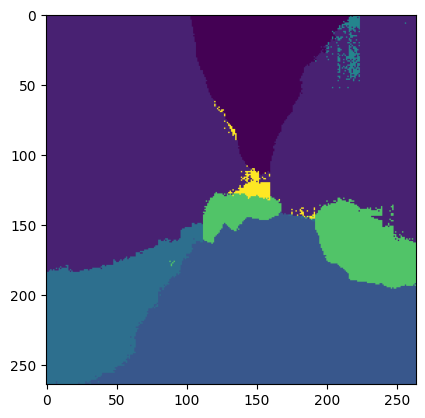

In [7]:
plt.imshow(out)

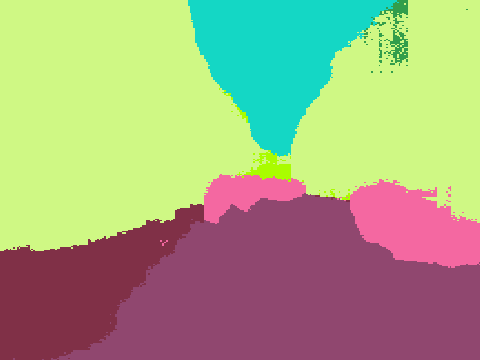

In [8]:
from IPython.display import Image
Image('/tmp/out.png')

In [9]:
o = model.predict_segmentation(
    inp="dataset1/images_prepped_test/0016E5_07965.png",
    out_fname="/tmp/out.png" , overlay_img=True, show_legends=True,
    class_names = [ "Sky",    "Building", "Pole","Road","Pavement","Tree","SignSymbol", "Fence", "Car","Pedestrian", "Bicyclist"]

)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


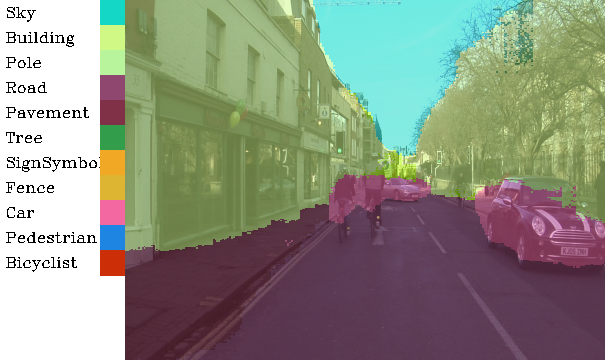

In [10]:
from IPython.display import Image
Image('/tmp/out.png')